# 隱含波動度濾網策略 (買權ATM價格=0.4* S * 買權ATM隱含波動度 *deltaT)
### 摘要：
本策略參考112選擇權_評價與應用（江彌修）上課內容，結合Implied Vol.透露市場對行情的預期，建構濾網策略，協助提升選擇權演算法交易報酬。
### 估計方法與資料處理：
1. 使用yfinance抓取台灣加權股價指數(^TWII)做為標的資產代理變數
2. 將1.的資料與/atm_option_settle.csv 合併
3. 使用次週週選結算價判斷估計「隱含波動度」
### 策略內容：
1. 判斷次週週選之「隱含波動度」有無大於指定條件，若有則進場直到下一期的次週週選，屆時再進行一次判斷，以此類推。
2. 分別建構三種策略：(1) +Call (2) +Put (3) +Call+Put
### 策略評估：
總合考量下列五指標，
1. 總報酬率
2. 年化報酬率
3. 年化波動率
4. 年化夏普值
5. 最大回撤(MDD)
### 研究發現：
使用濾網條件下，三種策略的報酬皆有提升，可推斷隱含波動度為一個富有有用資訊的濾網條件。

In [2]:
import yfinance as yf
import pandas as pd
import plotly.graph_objs as go  # 載入plotly套件
import numpy as np              # 載入numpy套件
import pandas as pd             # 載入pandas套件
import datetime as dt           # 載入datetime套件

def fetch_prices(ticker):
    dfs = yf.Ticker(ticker)
    start = '2020-01-01'
    end = '2023-09-01'
    hist = dfs.history(start=start, end=end, interval='1d')
    return hist

a = fetch_prices('^TWII')
a['Close'] = round(a['Close'], 2)

# 将日期时间格式转换为 'YYYY/MM/DD'
a.index = a.index.strftime('%Y-%m-%d')
a['日期'] = a.index
a.index = range(len(a))
a = a[['日期','Close']]
# 找到的
new_data = {'日期': '2021-04-06', 'Close': 16571.28}  # Close的值用'2021-04-0x'（有值的前一期，把判斷式刪掉了）帶入
# 将新行数据转换为DataFrame
new_row = pd.DataFrame(new_data, index=[0])
a = pd.concat([a, new_row]).sort_values(by='日期').reset_index(drop=True)
print(a)

atm_df = pd.read_csv('atm_option_settle.csv')
atm_df['日期'] = pd.to_datetime(atm_df['日期'])
atm_df['日期'] = atm_df['日期'].dt.strftime('%Y-%m-%d')
print(atm_df)


             日期     Close
0    2020-01-02  12100.48
1    2020-01-03  12110.43
2    2020-01-06  11953.36
3    2020-01-07  11880.32
4    2020-01-08  11817.10
..          ...       ...
886  2023-08-25  16481.58
887  2023-08-28  16509.26
888  2023-08-29  16623.65
889  2023-08-30  16719.82
890  2023-08-31  16634.51

[891 rows x 2 columns]
             日期  價平買權次週每日結算價  價平買權近週每日結算價  價平賣權次週每日結算價  價平賣權近週每日結算價
0    2020-01-02         68.0        102.0         56.0          0.1
1    2020-01-03          NaN         52.0          NaN         56.0
2    2020-01-06          NaN          5.4          NaN        147.0
3    2020-01-07          NaN          0.6          NaN        225.0
4    2020-01-08        136.0          0.1         99.0        260.0
..          ...          ...          ...          ...          ...
886  2023-08-25          NaN        167.0          NaN         67.0
887  2023-08-28          NaN        182.0          NaN         23.5
888  2023-08-29          NaN        291.0          N

In [3]:
merged_df = pd.merge(a, atm_df, on="日期", how="inner")
merged_df

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價
0,2020-01-02,12100.48,68.0,102.0,56.0,0.1
1,2020-01-03,12110.43,NaN,52.0,NaN,56.0
2,2020-01-06,11953.36,NaN,5.4,NaN,147.0
3,2020-01-07,11880.32,NaN,0.6,NaN,225.0
4,2020-01-08,11817.10,136.0,0.1,99.0,260.0
...,...,...,...,...,...,...
886,2023-08-25,16481.58,NaN,167.0,NaN,67.0
887,2023-08-28,16509.26,NaN,182.0,NaN,23.5
888,2023-08-29,16623.65,NaN,291.0,NaN,1.3
889,2023-08-30,16719.82,133.0,381.0,98.0,0.1


In [4]:
merged_df['Implied volatility of Call'] = 0
merged_df['Implied volatility of Put']  = 0
for i in range(0,len(merged_df)):
    merged_df['Implied volatility of Call'][i] = merged_df['價平買權次週每日結算價'][i]/0.4/merged_df['Close'][i]/((7/365)**0.5)
    # print(merged_df['Implied volatility of Call'][i])
    merged_df['Implied volatility of Put'][i] = merged_df['價平賣權次週每日結算價'][i]/0.4/merged_df['Close'][i]/((7/365)**0.5)

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2689708188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Implied volatility of Call'][i] = merged_df['價平買權次週每日結算價'][i]/0.4/merged_df['Close'][i]/((7/365)**0.5)
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2689708188.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Implied volatility of Put'][i] = merged_df['價平賣權次週每日結算價'][i]/0.4/merged_df['Close'][i]/((7/365)**0.5)


In [5]:
merged_df

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put
0,2020-01-02,12100.48,68.0,102.0,56.0,0.1,0.101448,0.083545
1,2020-01-03,12110.43,NaN,52.0,NaN,56.0,NaN,NaN
2,2020-01-06,11953.36,NaN,5.4,NaN,147.0,NaN,NaN
3,2020-01-07,11880.32,NaN,0.6,NaN,225.0,NaN,NaN
4,2020-01-08,11817.10,136.0,0.1,99.0,260.0,0.207762,0.151238
...,...,...,...,...,...,...,...,...
886,2023-08-25,16481.58,NaN,167.0,NaN,67.0,NaN,NaN
887,2023-08-28,16509.26,NaN,182.0,NaN,23.5,NaN,NaN
888,2023-08-29,16623.65,NaN,291.0,NaN,1.3,NaN,NaN
889,2023-08-30,16719.82,133.0,381.0,98.0,0.1,0.143601,0.105811


In [6]:
merged_df['Signal of Long Call'] = 0
merged_df['Signal of Long Put'] = 0
print(merged_df['Implied volatility of Call'].mean())
print(merged_df['Implied volatility of Put'].mean())
for i in range(0,len(merged_df)):
    # if merged_df['Implied volatility of Call'][i] > merged_df['Implied volatility of Call'].mean():
    if merged_df['Implied volatility of Call'][i] > 0.25:
        merged_df['Signal of Long Call'][i] = 1 
    else:
        merged_df['Signal of Long Call'][i] = 0
    # if merged_df['Implied volatility of Put'][i] > merged_df['Implied volatility of Put'].mean():
    if merged_df['Implied volatility of Put'][i] > 0.2:
        merged_df['Signal of Long Put'][i] = 1 
    else:
        merged_df['Signal of Long Put'][i] = 0
merged_df

0.22008917057817765
0.14855264158224382


/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2008433713.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Signal of Long Call'][i] = 0
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2008433713.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Signal of Long Put'][i] = 0
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2008433713.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put,Signal of Long Call,Signal of Long Put
0,2020-01-02,12100.48,68.0,102.0,56.0,0.1,0.101448,0.083545,0,0
1,2020-01-03,12110.43,NaN,52.0,NaN,56.0,NaN,NaN,0,0
2,2020-01-06,11953.36,NaN,5.4,NaN,147.0,NaN,NaN,0,0
3,2020-01-07,11880.32,NaN,0.6,NaN,225.0,NaN,NaN,0,0
4,2020-01-08,11817.10,136.0,0.1,99.0,260.0,0.207762,0.151238,0,0
...,...,...,...,...,...,...,...,...,...,...
886,2023-08-25,16481.58,NaN,167.0,NaN,67.0,NaN,NaN,0,0
887,2023-08-28,16509.26,NaN,182.0,NaN,23.5,NaN,NaN,0,0
888,2023-08-29,16623.65,NaN,291.0,NaN,1.3,NaN,NaN,0,0
889,2023-08-30,16719.82,133.0,381.0,98.0,0.1,0.143601,0.105811,0,0


In [7]:
merged_df['Signal of Long Call_E'] = 0
merged_df['Signal of Long Put_E'] = 0
prev_value1 = 0  # 儲存上一個非NaN值的index
prev_value2 = 0  # 儲存上一個非NaN值的index

for i in range(len(merged_df)):
    if not pd.isna(merged_df['價平買權次週每日結算價'][i]):  # 檢查a['1']是否為NA
        merged_df['Signal of Long Call_E'][i] = merged_df['Signal of Long Call'][i]
        prev_value1 = i
    else:
        merged_df['Signal of Long Call_E'][i] = merged_df['Signal of Long Call'][prev_value1]
        
    if not pd.isna(merged_df['價平賣權次週每日結算價'][i]):  # 檢查a['1']是否為NA
        merged_df['Signal of Long Put_E'][i] = merged_df['Signal of Long Put'][i]
        prev_value2 = i
    else:
        merged_df['Signal of Long Put_E'][i] = merged_df['Signal of Long Put'][prev_value2]
merged_df

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2203743435.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Signal of Long Call_E'][i] = merged_df['Signal of Long Call'][i]
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2203743435.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Signal of Long Put_E'][i] = merged_df['Signal of Long Put'][i]
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/2203743435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put,Signal of Long Call,Signal of Long Put,Signal of Long Call_E,Signal of Long Put_E
0,2020-01-02,12100.48,68.0,102.0,56.0,0.1,0.101448,0.083545,0,0,0,0
1,2020-01-03,12110.43,NaN,52.0,NaN,56.0,NaN,NaN,0,0,0,0
2,2020-01-06,11953.36,NaN,5.4,NaN,147.0,NaN,NaN,0,0,0,0
3,2020-01-07,11880.32,NaN,0.6,NaN,225.0,NaN,NaN,0,0,0,0
4,2020-01-08,11817.10,136.0,0.1,99.0,260.0,0.207762,0.151238,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2023-08-25,16481.58,NaN,167.0,NaN,67.0,NaN,NaN,0,0,1,0
887,2023-08-28,16509.26,NaN,182.0,NaN,23.5,NaN,NaN,0,0,1,0
888,2023-08-29,16623.65,NaN,291.0,NaN,1.3,NaN,NaN,0,0,1,0
889,2023-08-30,16719.82,133.0,381.0,98.0,0.1,0.143601,0.105811,0,0,0,0


In [8]:
# 測試用
# import pandas as pd
# import numpy as np

# data = {'1': [82, np.nan, np.nan, np.nan, 62, np.nan, np.nan, np.nan, 93, np.nan, np.nan, np.nan],
#         '2': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]}

# a = pd.DataFrame(data)
# a['3'] = 0

# prev_value = 0  # 儲存上一個非NaN值的index

# for i in range(len(a)):
#     if not pd.isna(a['1'][i]):  # 檢查a['1']是否為NA
#         a['3'][i] = a['2'][i]
#         prev_value = i
#     else:
#         a['3'][i] = a['2'][prev_value]

# result = a['3'].tolist()
# print(result)
# print(a)


In [9]:
merged_df.to_csv('/Users/shawn/Github/M1/價內shortPut策略程式/ck.csv')

In [10]:
# +Call
capital = 1000000
# 初始化策略累積資金
merged_df.loc[0, '策略累積資金(金額)'] = capital
results = []
merged_df.loc[0, '進場口數'] = 4

for i in range(1,len(merged_df['價平買權次週每日結算價'])):
    B = merged_df['價平買權次週每日結算價'][i - 1]
    B1 = merged_df['Signal of Long Call_E'][i - 1]
    C = merged_df['價平買權近週每日結算價'][i]

    if B*B1 > 1:
        result = round(C - B - 3 , 2)
        merged_df['進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

    else:
        C_prev = merged_df['價平買權近週每日結算價'][i-1]
        result = round(C - C_prev , 2)*B1
        
    merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
    merged_df.loc[i, '策略累積資金(金額)'] = merged_df.loc[i-1, '策略累積資金(金額)']+result*merged_df['進場口數'][i-1]*50
    
    results.append(result)

results.insert(0, 0)
print(results)
merged_df['策略近週報酬(點數)'] = results

# 總報酬率: 55.81%
# 年化報酬率: 13.36%
# 年化波動率: 19.89%
# 年化夏普值: 0.67
# 最大回撤(MDD): -20.88%

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/591000183.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/591000183.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/591000183.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

[0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 39.0, -113.0, 143.0, 2.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -170.5, -13.0, -18.0, -1.4, 0.2, -274.0, 224.0, -229.0, 286.0, 288.0, 13.0, -73.0, -48.0, -43.0, -26.0, 58.0, 139.0, 100.0, -41.0, -9.0, -51.0, 168.0, 101.0, -32.0, 161.0, -74.0, -193.0, -62.8, 17.0, -28.0, 191.0, 25.0, 129.0, 157.0, -226.0, 20.0, -47.0, 25.0, 25.0, 53.0, -113.0, 21.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 15.0, -4.0, -1.0, 30.0, 42.0, -129.0, 37.0, 101.0, 109.0, 122.0, 217.0, -40.0, 80.0, -0.0, -0.0, 0.0, -0.0, 0.0, -54.0, -13.0, -20.0, 226.0, 31.0, -29.0, -72.0, 231.0, -47.0, -43.0, 112.0, -19.0, -130.0, 143.0, 79.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.

/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/591000183.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/591000183.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
/var/folders/nm/qsv7jp0x4gxdpcssmk1d_bq00000gn/T/ipykernel_2440/591000183.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [11]:
# # +Put
# capital = 1000000
# # 初始化策略累積資金
# merged_df.loc[0, '策略累積資金(金額)'] = capital
# results = []
# merged_df.loc[0, '進場口數'] = 4

# for i in range(1,len(merged_df['價平賣權次週每日結算價'])):
#     B = merged_df['價平賣權次週每日結算價'][i - 1]
#     B1 = merged_df['Signal of Long Put_E'][i - 1]
#     C = merged_df['價平賣權近週每日結算價'][i]

#     if B*B1 > 1:
#         result = round(C - B - 3 , 2)
#         merged_df['進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

#     else:
#         C_prev = merged_df['價平賣權近週每日結算價'][i-1]
#         result = round(C - C_prev , 2)*B1
        
#     merged_df['進場口數'][i] = merged_df['進場口數'][i-1]
#     merged_df.loc[i, '策略累積資金(金額)'] = merged_df.loc[i-1, '策略累積資金(金額)']+result*merged_df['進場口數'][i-1]*50
    
#     results.append(result)

# results.insert(0, 0)
# print(results)
# # results = [-x for x in results]
# merged_df['策略近週報酬(點數)'] = results

# # 總報酬率: -23.79%
# # 年化報酬率: -7.4%
# # 年化波動率: 25.7%
# # 年化夏普值: -0.29
# # 最大回撤(MDD): -52.98%

In [12]:
# # +call-put
# capital = 1000000
# # 初始化策略累積資金
# merged_df.loc[0, '策略累積資金(金額)'] = capital
# results1 = []
# merged_df.loc[0, 'Call進場口數'] = 2
# results2 = []
# merged_df.loc[0, 'Put進場口數'] = 2

# for i in range(1,len(merged_df['價平買權次週每日結算價'])):
#     B = merged_df['價平買權次週每日結算價'][i - 1]
#     B1 = merged_df['Signal of Long Call_E'][i - 1]
#     C = merged_df['價平買權近週每日結算價'][i]

#     X = merged_df['價平賣權次週每日結算價'][i - 1]
#     X1 = merged_df['Signal of Long Put_E'][i - 1]
#     Y = merged_df['價平賣權近週每日結算價'][i]

#     if B*B1 > 1:
#         result1 = round(C - B - 3 , 2)
#         merged_df['Call進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

#     else:
#         C_prev = merged_df['價平買權近週每日結算價'][i-1]
#         result1 = round(C - C_prev , 2)*B1

#     if X*X1 > 1:
#         result2 = round(Y - X - 3 , 2)
#         merged_df['Put進場口數'][i-1] = round(merged_df.loc[i-1, '策略累積資金(金額)']/250000)

#     else:
#         Y_prev = merged_df['價平賣權近週每日結算價'][i-1]
#         result2 = round(Y_prev - Y , 2)*X1
        
#     merged_df['Call進場口數'][i] = merged_df['Call進場口數'][i-1]
#     merged_df['Put進場口數'][i] = merged_df['Put進場口數'][i-1]
#     merged_df.loc[i, '策略累積資金(金額)'] = merged_df.loc[i-1, '策略累積資金(金額)']+result1*merged_df['Call進場口數'][i-1]*50+result2*merged_df['Put進場口數'][i-1]*50
    
#     results1.append(result1)
#     results2.append(result2)

# results1.insert(0, 0)
# results2.insert(0, 0)

# # results = [-x for x in results]
# merged_df['Call策略近週報酬(點數)'] = results1
# merged_df['Put策略近週報酬(點數)'] = results2

# 總報酬率: 63.67%
# 年化報酬率: 14.95%
# 年化波動率: 26.3%
# 年化夏普值: 0.57
# 最大回撤(MDD): -28.99%

<Axes: >

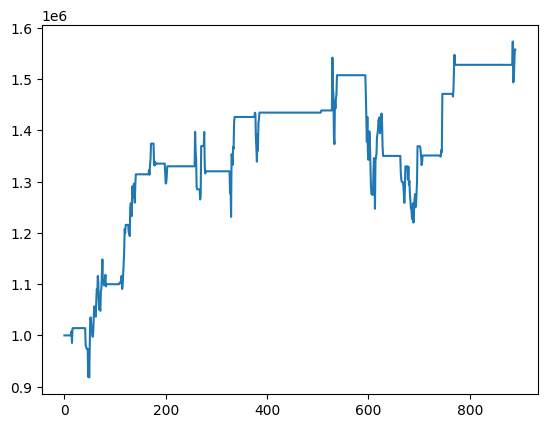

In [13]:
merged_df.to_csv('/Users/shawn/Github/M1/價內shortPut策略程式/IV_CallPut.csv')
merged_df['策略累積資金(金額)'].plot()

In [14]:
backtest_df = merged_df
backtest_df['策略每日報酬率'] = backtest_df['策略累積資金(金額)'].pct_change()
backtest_df.loc[0, '策略每日報酬率'] = 0  # 初始化第一天策略每日報酬率

# 計算累積報酬率
backtest_df['策略累積報酬率'] = (1 + backtest_df['策略每日報酬率']).cumprod()-1
backtest_df.loc[0, '策略累積報酬率'] = 0  # 初始化第一天策略累積報酬率

# 計算Drawdown
# 計算每個時間點的最大價格
backtest_df['每個時點最大策略累積資金(金額)'] = backtest_df['策略累積資金(金額)'].cummax()
# 計算每個時間點的 Drawdown
backtest_df['Drawdown'] = (backtest_df['策略累積資金(金額)'] - backtest_df['每個時點最大策略累積資金(金額)']) / backtest_df['每個時點最大策略累積資金(金額)']
# backtest_df.to_csv('/Users/shawn/Github/M1/價內shortPut策略程式/backtest.csv')
backtest_df.head(5)

,日期,Close,價平買權次週每日結算價,價平買權近週每日結算價,價平賣權次週每日結算價,價平賣權近週每日結算價,Implied volatility of Call,Implied volatility of Put,Signal of Long Call,Signal of Long Put,Signal of Long Call_E,Signal of Long Put_E,策略累積資金(金額),進場口數,策略近週報酬(點數),策略每日報酬率,策略累積報酬率,每個時點最大策略累積資金(金額),Drawdown
0,2020-01-02,12100.48,68.0,102.0,56.0,0.1,0.101448,0.083545,0,0,0,0,1000000.0,4.0,0.0,0.0,0.0,1000000.0,0.0
1,2020-01-03,12110.43,NaN,52.0,NaN,56.0,NaN,NaN,0,0,0,0,1000000.0,4.0,-0.0,0.0,0.0,1000000.0,0.0
2,2020-01-06,11953.36,NaN,5.4,NaN,147.0,NaN,NaN,0,0,0,0,1000000.0,4.0,-0.0,0.0,0.0,1000000.0,0.0
3,2020-01-07,11880.32,NaN,0.6,NaN,225.0,NaN,NaN,0,0,0,0,1000000.0,4.0,-0.0,0.0,0.0,1000000.0,0.0
4,2020-01-08,11817.10,136.0,0.1,99.0,260.0,0.207762,0.151238,0,0,0,0,1000000.0,4.0,-0.0,0.0,0.0,1000000.0,0.0


In [15]:
from plotly.subplots import make_subplots  #載入plotly畫子圖的套件

# 定義繪製策略損益圖方法
def draw_PnL(trace1, trace2,  title1, title2):
    
    # 打開子畫布
    fig = make_subplots(rows=2, cols=1, subplot_titles=(title1, title2), row_heights=[0.75, 0.25], shared_xaxes=True, vertical_spacing=0.1)
    
    # 帶入資料到子畫布的特定位置
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=2, col=1)
    
    # 設定子畫布共同屬性
    fig.update_layout(
        title='做空賣權策略績效', # 設定圖表標題名稱
        plot_bgcolor='white', # 設定底色為白色
    )
    
    # 設定子畫布屬性
    fig.update_xaxes(row=1, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey')
    fig.update_yaxes(title_text="損益(%)", row=1, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey', zerolinecolor='darkgrey')
    fig.update_xaxes(title_text="日期", row=2, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey')
    fig.update_yaxes(title_text="損益(%)", row=2, col=1, linecolor='black', linewidth=2, showgrid=True, gridcolor='lightgrey', zerolinecolor='darkgrey')

    #展示圖表
    fig.show()
    
    return

In [16]:
# 建立plotly損益曲線
trace1 = go.Scatter(x=backtest_df['日期'], 
                    y=backtest_df['策略累積報酬率']*100, 
                    mode='lines', 
                    name='做空賣權策略損益', 
                    line=dict(color='blue')
                    )
trace2 = go.Scatter(x=backtest_df['日期'], 
                    y=backtest_df['Drawdown']*100, 
                    mode='lines', 
                    name='Drawdown', 
                    line=dict(color='red')
                    )

# 繪製策略損益圖
draw_PnL(trace1, trace2, '策略損益曲線', 'Drawdown')

In [17]:
# 計算績效指標
total_return = backtest_df.loc[len(backtest_df)-1, '策略累積報酬率']
annualized_return = (1+backtest_df.loc[len(backtest_df)-1, '策略累積報酬率'])**(252/len(backtest_df))-1  # 年化報酬率
annualized_volatility = np.std(backtest_df['策略每日報酬率'])*np.sqrt(252)  # 年化波動率
sharpe_ratio = annualized_return/annualized_volatility  # 年化夏普值
max_drawdown = backtest_df['Drawdown'].min()  # 最大回撤(MDD)

print("總報酬率: {}%".format(round(total_return*100,2)))
print("年化報酬率: {}%".format(round(annualized_return*100,2)))
print("年化波動率: {}%".format(round(annualized_volatility*100,2)))
print("年化夏普值: {}".format(round(sharpe_ratio,2))) 
print("最大回撤(MDD): {}%".format(round(max_drawdown*100,2)))

總報酬率: 55.81%
年化報酬率: 13.36%
年化波動率: 19.89%
年化夏普值: 0.67
最大回撤(MDD): -20.88%
